In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.text import *
import pickle
import pandas as pd
import html

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH=Path('/home/paperspace/data/mimic-iii')
LM_PATH=PATH/'exp-2'

In [4]:
trn_ids = np.load(LM_PATH/'trn_ids_concat.npy')
val_ids = np.load(LM_PATH/'val_ids_concat.npy')

In [5]:
with open(LM_PATH/'itos.pickle', 'rb') as handle:
    itos = pickle.load(handle)
    
vocab_size=len(itos)

In [6]:
em_sz,nh,nl = 400,1150,3
bptt, bs = 70, 64

In [7]:
trn_dl = LanguageModelLoader(trn_ids, bs, bptt)
val_dl = LanguageModelLoader(val_ids, bs, bptt)
md = LanguageModelData(PATH, 0, vocab_size, trn_dl, val_dl, bs=bs, bptt=bptt)

In [8]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.5

In [9]:
opt_fn = partial(optim.Adam, betas=(0.8,0.99))
learner= md.get_model(opt_fn, em_sz, nh, nl,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])
learner.metrics = [accuracy]
learner.clip=0.12
learner.unfreeze()
learner.reg_fn=partial(seq2seq_reg, alpha=2, beta=1)
wd = 1e-7

In [10]:
learner.lr_find(end_lr=1000)

 46%|████▋     | 8130/17529 [42:41<49:21,  3.17it/s, loss=11.8]  

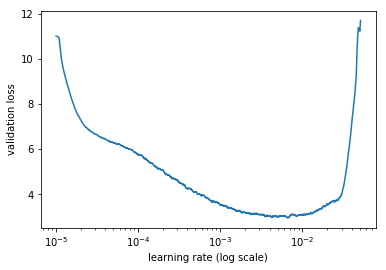

In [11]:
learner.sched.plot()

In [12]:
lr = 10e-3

In [13]:
learner.fit(lr, 1, cycle_len=10, use_clr_beta=(10,10,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                         
    0      2.729876   2.676484   0.506257  
    1      2.592066   2.496985   0.529427                         
    2      2.607659   2.49722    0.530698                         
    3      2.638773   2.524335   0.527946                         
    4      2.599755   2.512521   0.52966                          
    5      2.611442   2.460475   0.536182                         
    6      2.529687   2.414329   0.54212                          
    7      2.485293   2.368858   0.548198                         
    8      2.463634   2.330411   0.553335                         
    9      2.450952   2.315072   0.555576                         


[array([2.31507]), 0.5555761447306623]

In [ ]:
learner.sched.plot_loss(n_skip=20000)

In [60]:
learner.save('experiment-2-word_level_lowercase')

In [61]:
learner.load('experiment-2-word_level_lowercase')

In [79]:
m = learner.model

with open(LM_PATH/'stoi.pickle','rb') as f:
    stoi = pickle.load(f)

def sample_model(m, s, l=100):
    s_toks = Tokenizer().proc_text(s)
    s_nums = [stoi[i] for i in s_toks]
    s_var = V(np.array(s_nums))[None]

    m[0].bs=1
    m.eval()
    m.reset()

    res, *_ = m(s_var)
    print('...', end='')

    for i in range(l):
        r = torch.multinomial(res[-1].exp(), 2)
        #r = torch.topk(res[-1].exp(), 2)[1]
        if r.data[0] == 0:
            r = r[1]
        else:
            r = r[0]
        
        word = itos[to_np(r)[0]]
        res, *_ = m(r[0].unsqueeze(0))
        print(word, end=' ')
    m[0].bs=bs

In [80]:
s = 'cardiovascular system '
sample_model(m, s)

...assisted with activities . ordered to ct scan of her chest at approximately rising previous 50mcgs spared changefrom boot removed in the setting of marked 92status . ap neuro examination : on face tent there was during admit to the micu , following intubation , 100.9 degrees . extensor posturing and became [ * * last name ( un ) * * ] stim . slight clonus , eyes open , unable to examsee care two times , not to call or following commands , ng tube was also clamped . notable rl , speaking 75 4 t - sicu 

In [81]:
s = 'blood loss '
sample_model(m, s)

...of nopericardial air- edema , flat and hrs.gi right mchc-34.9 . no signs of infection ezetimibe , home paperwork . [ * * doctor last name * * ] consulted , recommended euvolemic respirations 30 . if weight operation , would recommend lasix . xeos 
 xbos [ * * 2128 - 4 - 22 * * ] patient - t kept to 3vd r femoral with 2 vessel cad and for sequela of cabg with pci , presumed lmca infarct right e.neuro without intervention , svg to index and day5 - om2 symmetric 60 - 70 , o 33.3 